# Quantum Machine Learning for Music Genre Classification

The aim of the this tutorial is to demonstrate use of HierarQcal to create quantum circuit models for classification tasks. Specifically for this tutorial we will use the [GTZAN dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download) to classify country and rock songs.

We start with a 30-s recording of a song (Fig. 1a) and we can transform it in two ways. The ﬁrst is tabular form(Fig. 1b), derived from standard digital signal processing statistics of the audio signal. The second is image form (Fig. 1c), constructed using a Mel-frequency spectrogram. In this tutorial, we will use the tabular form data.

<center>
<img src="./assets/2023_hierarqcal_qcnn_pipeline.svg" alt='qcnn_genre_classification'/>
</center>

In [1]:
# needed for inline plots in some contexts
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# allow "hot-reloading" of modules
%load_ext autoreload
%autoreload 2

In [2]:
# Go to parent directory i.e. classification
# and set python path
%cd ..
%env PYTHONPATH=.:$PYTHONPATH

/home/gopald/Documents/hierarqcal/examples/classification
env: PYTHONPATH=.:$PYTHONPATH


## Training a `QCNN` on `GTZAN` using `run_expt`

Lets use HierarQcal's HierarQML for training a `QCNN` on `GTZAN` dataset. 

- The dataset is preprocessed using Min Max Scaling and PCA. The scaling is performed prior to PCA to make to feature range between $[0, \pi/2]$. The number of components is specified i.e. 8.
- We use `AngleEmbedding` from PennyLane with the `R_x` rotations.
- Other hyperparameters including the path of the data, batch size, epochs and learning rate are used.

In [3]:
from hierarqml.utils import get_circuit
from training.ansatz import get_motif
import pennylane as qml
import torch

(<Figure size 9500x900 with 1 Axes>, <Axes: >)

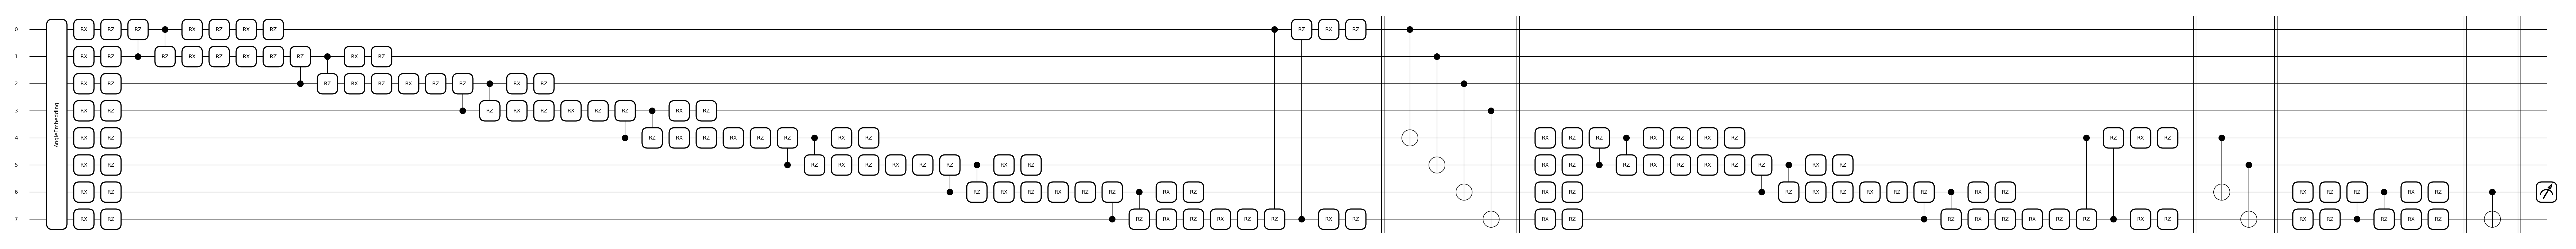

In [4]:
motif = get_motif(8)
qnode = get_circuit(motif, embedding="AngleEmbedding", rotation='X')

x, w = torch.rand(8), torch.rand(motif.n_symbols)
qml.draw_mpl(qnode)(x, w)

In [5]:
## utility function to draw plots

def visualize(df):
    fig,ax = plt.subplots(1,2,figsize=(12,5))

    ax[0].plot(df_grp.index, df_grp['train_loss'])
    ax[0].plot(df_grp.index, df_grp['val_loss'])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss vs. No. of epochs');

    ax[1].plot(df_grp.index, df_grp['train_acc'])
    ax[1].plot(df_grp.index, df_grp['val_acc'])
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend(['train_acc', 'val_acc'])
    ax[1].set_title('Accuracy vs. No. of epochs');

In [6]:
!python training/run_expt.py \
--data_class GTZAN \
--model_class QCNN \
--embedding AngleEmbedding \
--rotation X \
--data_path ./Data/features_30_sec.csv \
--pca 8 \
--batch_size 16 --max_epochs 20 --lr 0.01

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
GENRS ('classical', 'rock')
Missing logger folder: csv_logs/lightning_logs

  | Name      | Type     | Params
---------------------------------------
0 | model     | QCNN     | 30    
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | Accuracy | 0     
---------------------------------------
30        Trainable params
0         Non-trainable params
30        Total params
0.000     Total estimated model params size (MB)
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batc

During training, logs are saved in `csv_logs` as we use the `pl.loggers.CSVLogger`. However, there are many loggers available to use. We can visualize the training/validation loss and accuracy.

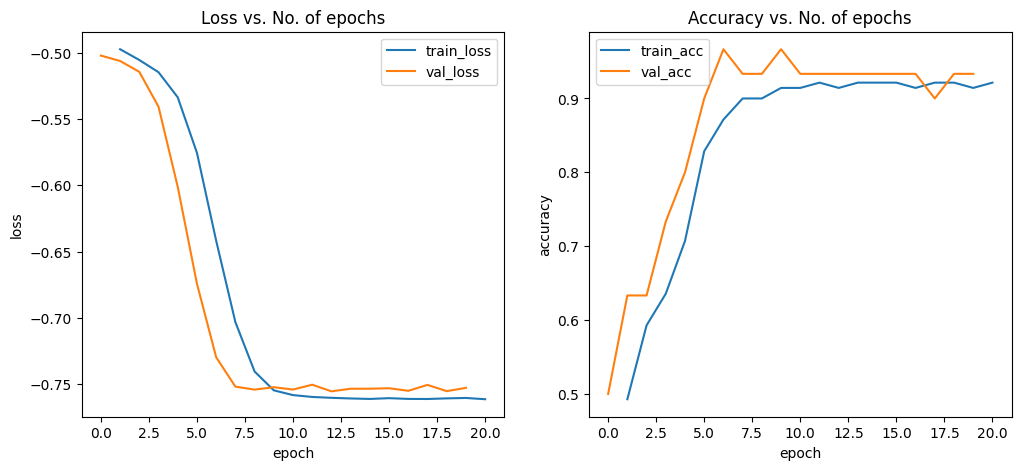

In [7]:
df = pd.read_csv('./csv_logs/lightning_logs/version_0/metrics.csv')
df_grp = df.groupby('epoch').mean()
visualize(df)

Let's now train the model using `AmplitudeEmbedding` using 4 qubits. On 4 qubits we can embed upto 16 features so we will set the number of components in PCA to 16.

(<Figure size 4100x500 with 1 Axes>, <Axes: >)

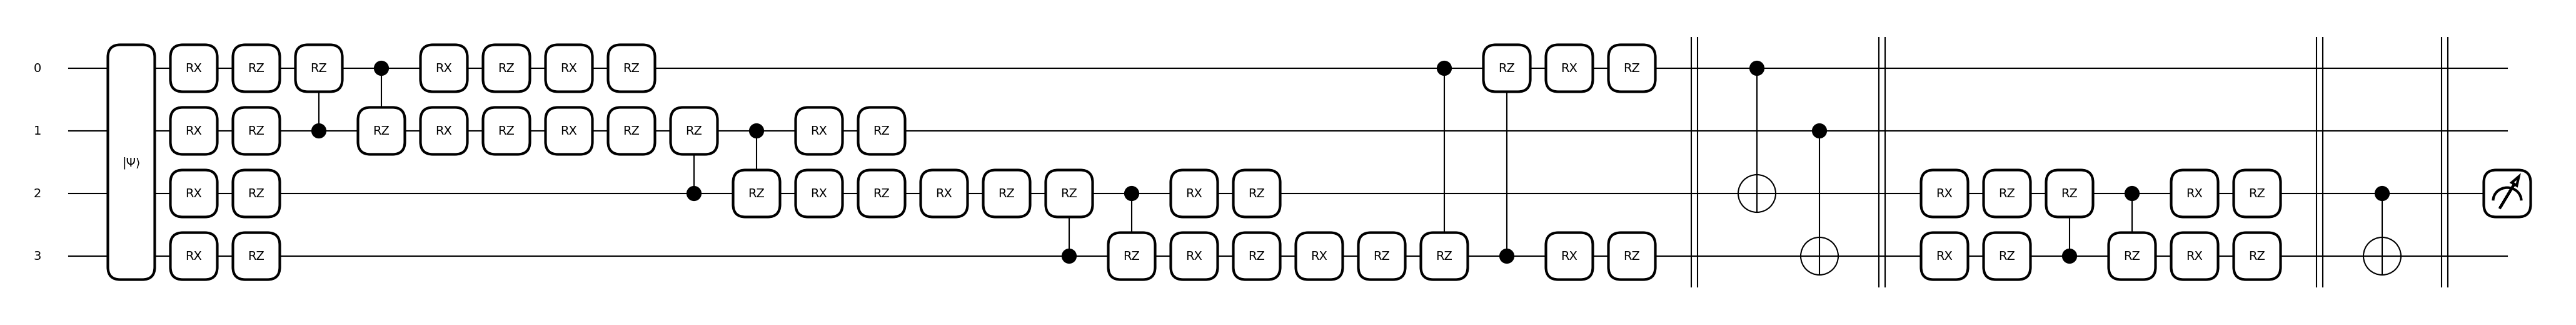

In [8]:
motif = get_motif(4)
qnode = get_circuit(motif, embedding="AmplitudeEmbedding", normalize=1)

x, w = torch.rand(2**4), torch.rand(motif.n_symbols)
qml.draw_mpl(qnode)(x, w)

In [9]:
!python training/run_expt.py \
--data_class GTZAN \
--model_class QCNN \
--embedding AmplitudeEmbedding \
--normalize 1 \
--data_path ./Data/features_30_sec.csv \
--pca 32 \
--batch_size 16 --max_epochs 30 --lr 0.01

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
GENRS ('classical', 'rock')

  | Name      | Type     | Params
---------------------------------------
0 | model     | QCNN     | 20    
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | Accuracy | 0     
---------------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Tr

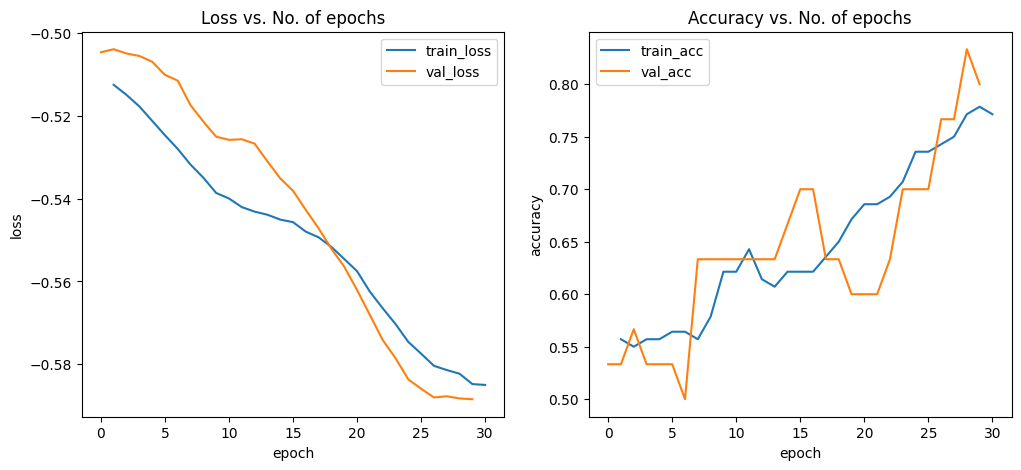

In [11]:
df = pd.read_csv('./csv_logs/lightning_logs/version_1/metrics.csv')
df_grp = df.groupby('epoch').mean()
visualize(df)

## How to use custom HierarQcal motifs?

To use custom motifs, one needs to create a python file with a function name `get_motif`. The function takes only a single parameter `n` which denotes the number of qubits. An example implemenation is given in `training/ansatz`. Lets create a python file with custom ansatz.

In [12]:
%%writefile custom_motif.py

# Example: Simpler ansatz, and construct it with hierarqcal...setting share_weights to False increases accuracy

from hierarqcal import Qinit, Qmotif, Qcycle, Qmask
from hierarqml.utils import hierq_gates
import numpy as np

ansatz = (
    Qinit(2)
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRY"])
    + Qmotif(E=[(1, 0)], mapping=hierq_gates["CRY"])
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CNOT"])
)
# pooling ansatz
p_ansatz = (
    Qinit(2)
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRZ"])
    + Qmotif(E=[(0,)], mapping=hierq_gates["PauliX"])
    + Qmotif(E=[(0, 1)], mapping=hierq_gates["CRX"])
)

def get_motif(n):
    # try setting share weights False
    qcnn = (
        Qinit(n)
        + (
            Qcycle(
                stride=1,
                step=1,
                offset=0,
                mapping=ansatz,
                share_weights=True,
            )
            + Qmask("01", mapping=p_ansatz)
        )
        * int(np.log2(n))
    )
    return qcnn

Writing custom_motif.py


(<Figure size 5800x900 with 1 Axes>, <Axes: >)

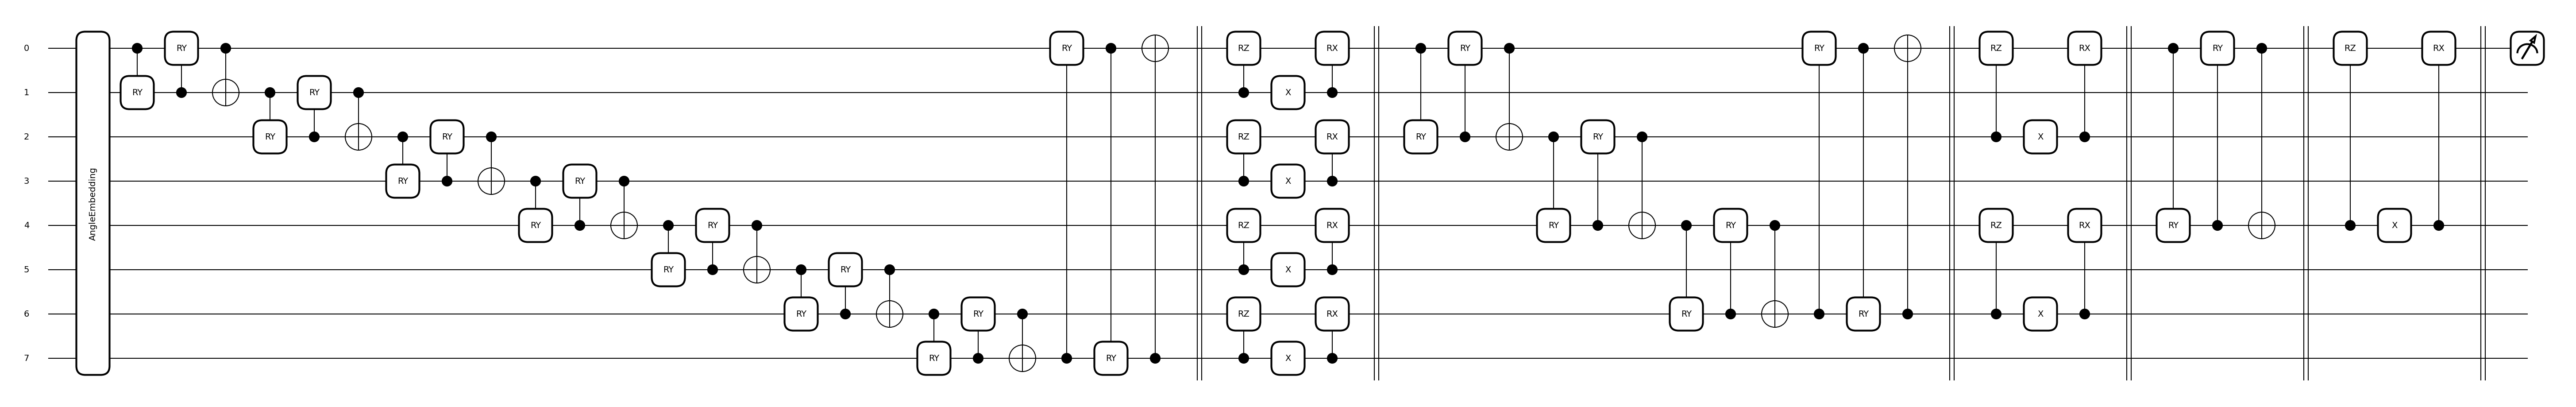

In [13]:
from custom_motif import get_motif

motif = get_motif(8)
qnode = get_circuit(motif, embedding="AngleEmbedding", rotation='X')

x, w = torch.rand(8), torch.rand(motif.n_symbols)
qml.draw_mpl(qnode)(x, w)

Specify the file path with the `--ansatz` argument. Do not write the file extension

In [16]:
!python training/run_expt.py \
--data_class GTZAN \
--model_class QCNN \
--embedding AngleEmbedding \
--rotation Y \
--data_path ./Data/features_30_sec.csv \
--pca 8 \
--batch_size 16 --max_epochs 20 --lr 0.01 \
--ansatz ./custom_motif

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
GENRS ('classical', 'rock')

  | Name      | Type     | Params
---------------------------------------
0 | model     | QCNN     | 12    
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | Accuracy | 0     
---------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
/home/gopald/Documents/hq-env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (9) is smaller than the logging interval Tr

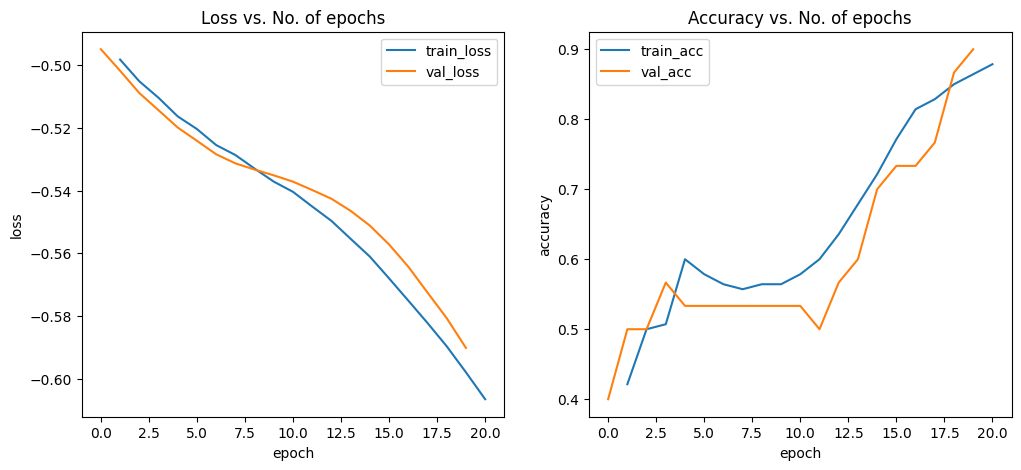

In [17]:
df = pd.read_csv('./csv_logs/lightning_logs/version_2/metrics.csv')
df_grp = df.groupby('epoch').mean()
visualize(df)

## Conclusion

In this tutorial, we used HierarQML which is built on top of HierarQcal and performed classification of songs in country and rock genre from the GTZAN dataset. We see there are good reasons to use a framework to organize training and provide fixed interfaces and abstractions.